<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/ADMM/Distributed_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!rm -rfv node_*

removed 'node_0_data.csv'
removed 'node_0_progress.csv'
removed 'node_1_data.csv'
removed 'node_1_progress.csv'
removed 'node_2_data.csv'
removed 'node_2_progress.csv'
removed 'node_3_data.csv'
removed 'node_3_progress.csv'
removed 'node_4_data.csv'
removed 'node_4_progress.csv'


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Parameters
n_samples = 50000
n_nodes = 5
samples_per_node = n_samples // n_nodes
n_features = 2  # For contour visualization

# np.random.seed(42)

# Generate synthetic data
X = np.random.uniform(0, 10, size=(n_samples, n_features))
w_true = np.random.uniform(0.5, 2.0, size=(n_features,))
y = X.dot(w_true) + np.random.normal(0, 10.0, size=n_samples)

# Shuffle and split
indices = np.arange(n_samples)
np.random.shuffle(indices)

for node_id in range(n_nodes):
    start = node_id * samples_per_node
    end = (node_id + 1) * samples_per_node if node_id < n_nodes - 1 else n_samples

    node_indices = indices[start:end]
    X_node = X[node_indices]
    y_node = y[node_indices]

    df_node = pd.DataFrame(X_node, columns=['x1', 'x2'])
    df_node['y'] = y_node

    filename = f'node_{node_id}_data.csv'
    df_node.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(df_node)} samples.")

print('True Weights:', w_true)


Saved node_0_data.csv with 10000 samples.
Saved node_1_data.csv with 10000 samples.
Saved node_2_data.csv with 10000 samples.
Saved node_3_data.csv with 10000 samples.
Saved node_4_data.csv with 10000 samples.
True Weights: [0.97733167 1.61639583]


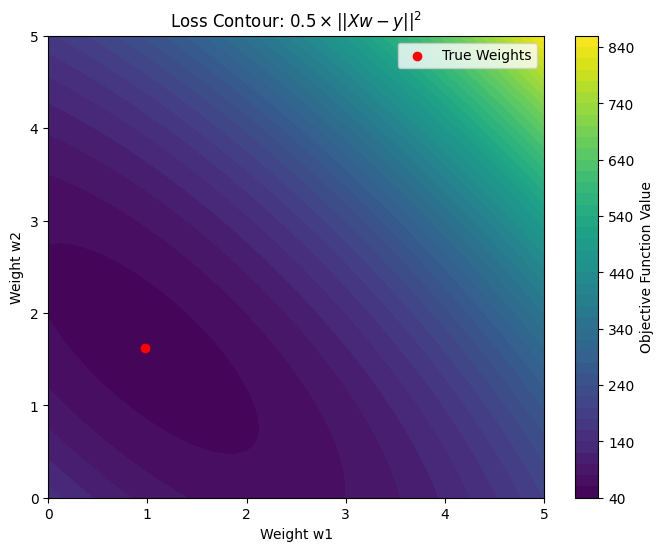

In [74]:
# Grid for weights (w1, w2)
w1_range = np.linspace(0, 5, 100)
w2_range = np.linspace(0, 5, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)

# Compute objective function values over the grid
loss_surface = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w_candidate = np.array([W1[i, j], W2[i, j]])
        predictions = X.dot(w_candidate)
        loss_surface[i, j] = 0.5 * np.mean((predictions - y)**2)

# Plot contour
plt.figure(figsize=(8,6))
contour = plt.contourf(W1, W2, loss_surface, levels=50, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.xlabel('Weight w1')
plt.ylabel('Weight w2')
plt.title('Loss Contour: $0.5 \\times || Xw - y ||^2$')
plt.scatter([w_true[0]], [w_true[1]], color='red', label='True Weights')
plt.legend()
plt.show()


In [75]:
%%writefile cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>

#define NODES 5
#define FEATURES 2
#define SAMPLES_PER_NODE 10000
#define MAX_ITERS 5000
#define TOL 1e-4
#define LEARNING_RATE 0.01f

__global__ void local_update_kernel(
    float *X_local, float *y_local,
    float *w_local, float *z_global, float *u_local,
    float rho, int samples_per_node)
{
    int node_id = threadIdx.x;
    if (node_id < NODES) {
        float grad[FEATURES] = {0.0f, 0.0f};
        float xi[FEATURES];
        float yi, prediction, error;

        for (int sample = 0; sample < samples_per_node; sample++) {
            int base_idx = node_id * samples_per_node * FEATURES + sample * FEATURES;
            xi[0] = X_local[base_idx + 0];
            xi[1] = X_local[base_idx + 1];
            yi = y_local[node_id * samples_per_node + sample];

            prediction = xi[0] * w_local[node_id * FEATURES + 0] + xi[1] * w_local[node_id * FEATURES + 1];
            error = prediction - yi;

            grad[0] += xi[0] * error;
            grad[1] += xi[1] * error;
        }

        grad[0] /= samples_per_node;
        grad[1] /= samples_per_node;

        for (int j = 0; j < FEATURES; j++) {
            float local_term = rho * (w_local[node_id * FEATURES + j] - z_global[j] + u_local[node_id * FEATURES + j]);
            w_local[node_id * FEATURES + j] -= LEARNING_RATE * (grad[j] + local_term);
        }
    }
}

void consensus_update(float *w_local, float *z_global, float *u_local) {
    float sum[FEATURES] = {0.0f, 0.0f};

    for (int node = 0; node < NODES; node++) {
        for (int j = 0; j < FEATURES; j++) {
            sum[j] += w_local[node * FEATURES + j] + u_local[node * FEATURES + j];
        }
    }

    for (int j = 0; j < FEATURES; j++) {
        z_global[j] = sum[j] / NODES;
    }

    for (int node = 0; node < NODES; node++) {
        for (int j = 0; j < FEATURES; j++) {
            u_local[node * FEATURES + j] += w_local[node * FEATURES + j] - z_global[j];
        }
    }
}

void log_weights(FILE *f_global, FILE *f_nodes[], int iter, float *z_global, float *w_local) {
    fprintf(f_global, "%d,%.6f,%.6f\n", iter, z_global[0], z_global[1]);
    for (int node = 0; node < NODES; node++) {
        fprintf(f_nodes[node], "%d,%.6f,%.6f\n", iter,
                w_local[node * FEATURES + 0],
                w_local[node * FEATURES + 1]);
    }
}

void read_csv_file(const char* filename, float* X_node, float* y_node, int samples) {
    FILE* file = fopen(filename, "r");
    if (!file) {
        printf("Error opening %s\n", filename);
        exit(1);
    }
    printf("Reading %s...\n", filename);

    char line[256];
    int count = 0;

    while (fgets(line, sizeof(line), file) != NULL && count < samples) {
        float x1, x2, y;
        if (sscanf(line, "%f,%f,%f", &x1, &x2, &y) == 3) {
            X_node[count * FEATURES + 0] = x1;
            X_node[count * FEATURES + 1] = x2;
            y_node[count] = y;
            count++;
        } else {
            printf("Skipping malformed line: %s\n", line);
        }
    }

    fclose(file);

    if (count < samples) {
        printf("Warning: %s only had %d samples\n", filename, count);
    }
}


int main() {
    float rho = 0.1f;

    float *h_X_local = (float*)malloc(NODES * SAMPLES_PER_NODE * FEATURES * sizeof(float));
    float *h_y_local = (float*)malloc(NODES * SAMPLES_PER_NODE * sizeof(float));
    float *h_w_local = (float*)calloc(NODES * FEATURES, sizeof(float));
    float *h_u_local = (float*)calloc(NODES * FEATURES, sizeof(float));
    float *h_z_global = (float*)calloc(FEATURES, sizeof(float));

    // Load CSVs
    for (int node = 0; node < NODES; node++) {
        char filename[64];
        sprintf(filename, "node_%d_data.csv", node);
        printf("Reading %s...\n", filename);

        read_csv_file(
            filename,
            &h_X_local[node * SAMPLES_PER_NODE * FEATURES],
            &h_y_local[node * SAMPLES_PER_NODE],
            SAMPLES_PER_NODE
        );
    }

    float *d_X_local, *d_y_local, *d_w_local, *d_u_local, *d_z_global;
    cudaMalloc(&d_X_local, NODES * SAMPLES_PER_NODE * FEATURES * sizeof(float));
    cudaMalloc(&d_y_local, NODES * SAMPLES_PER_NODE * sizeof(float));
    cudaMalloc(&d_w_local, NODES * FEATURES * sizeof(float));
    cudaMalloc(&d_u_local, NODES * FEATURES * sizeof(float));
    cudaMalloc(&d_z_global, FEATURES * sizeof(float));

    cudaMemcpy(d_X_local, h_X_local, NODES * SAMPLES_PER_NODE * FEATURES * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_y_local, h_y_local, NODES * SAMPLES_PER_NODE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w_local, h_w_local, NODES * FEATURES * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_u_local, h_u_local, NODES * FEATURES * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_z_global, h_z_global, FEATURES * sizeof(float), cudaMemcpyHostToDevice);

    FILE *f_global = fopen("global_progress.csv", "w");
    fprintf(f_global, "iteration,x1,x2\n");

    FILE *f_nodes[NODES];
    for (int i = 0; i < NODES; i++) {
        char filename[64];
        sprintf(filename, "node_%d_progress.csv", i);
        f_nodes[i] = fopen(filename, "w");
        fprintf(f_nodes[i], "iteration,x1,x2\n");
    }

    printf("Starting ADMM Consensus Training...\n");

    for (int iter = 0; iter < MAX_ITERS; iter++) {
        local_update_kernel<<<1, NODES>>>(d_X_local, d_y_local, d_w_local, d_z_global, d_u_local, rho, SAMPLES_PER_NODE);
        cudaDeviceSynchronize();

        cudaMemcpy(h_w_local, d_w_local, NODES * FEATURES * sizeof(float), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_u_local, d_u_local, NODES * FEATURES * sizeof(float), cudaMemcpyDeviceToHost);

        consensus_update(h_w_local, h_z_global, h_u_local);

        cudaMemcpy(d_z_global, h_z_global, FEATURES * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_u_local, h_u_local, NODES * FEATURES * sizeof(float), cudaMemcpyHostToDevice);

        log_weights(f_global, f_nodes, iter, h_z_global, h_w_local);

        float res_norm = 0.0f;
        for (int node = 0; node < NODES; node++) {
            for (int j = 0; j < FEATURES; j++) {
                float diff = h_w_local[node * FEATURES + j] - h_z_global[j];
                res_norm += diff * diff;
            }
        }
        res_norm = sqrtf(res_norm);

        if (iter % 10 == 0) {
            printf("Iter %d: Residual = %.6f\n", iter, res_norm);
        }

        if (res_norm < TOL) {
            printf("Converged at iteration %d\n", iter);
            break;
        }
    }

    printf("Final Consensus Model (z): w1 = %.4f, w2 = %.4f\n", h_z_global[0], h_z_global[1]);

    fclose(f_global);
    for (int i = 0; i < NODES; i++) {
        fclose(f_nodes[i]);
    }

    free(h_X_local); free(h_y_local); free(h_w_local); free(h_u_local); free(h_z_global);
    cudaFree(d_X_local); cudaFree(d_y_local); cudaFree(d_w_local); cudaFree(d_u_local); cudaFree(d_z_global);

    return 0;
}


Overwriting cuda.cu


In [76]:
import pandas as pd
pd.read_csv('node_0_data.csv')

,x1,x2,y
0,1.662448,9.774386,8.434228
1,6.373165,9.122085,17.837303
2,8.627514,5.666273,9.069657
3,0.378352,8.912006,23.638938
4,6.261773,4.421157,-11.132867
...,...,...,...
9995,3.353197,8.326338,25.032491
9996,2.384124,5.760336,-4.817245
9997,0.117573,8.315571,27.424120
9998,7.569580,5.423188,10.926623


In [77]:
!nvcc -gencode arch=compute_75,code=sm_75 cuda.cu -o cuda
!time ./cuda

Reading node_0_data.csv...
Reading node_0_data.csv...
Skipping malformed line: x1,x2,y

Reading node_1_data.csv...
Reading node_1_data.csv...
Skipping malformed line: x1,x2,y

Reading node_2_data.csv...
Reading node_2_data.csv...
Skipping malformed line: x1,x2,y

Reading node_3_data.csv...
Reading node_3_data.csv...
Skipping malformed line: x1,x2,y

Reading node_4_data.csv...
Reading node_4_data.csv...
Skipping malformed line: x1,x2,y

Starting ADMM Consensus Training...
Iter 0: Residual = 0.025666
Iter 10: Residual = 0.030470
Iter 20: Residual = 0.041308
Iter 30: Residual = 0.044983
Iter 40: Residual = 0.044284
Iter 50: Residual = 0.041469
Iter 60: Residual = 0.037860
Iter 70: Residual = 0.034146
Iter 80: Residual = 0.030660
Iter 90: Residual = 0.027537
Iter 100: Residual = 0.024813
Iter 110: Residual = 0.022476
Iter 120: Residual = 0.020493
Iter 130: Residual = 0.018823
Iter 140: Residual = 0.017424
Iter 150: Residual = 0.016254
Iter 160: Residual = 0.015277
Iter 170: Residual = 0.01

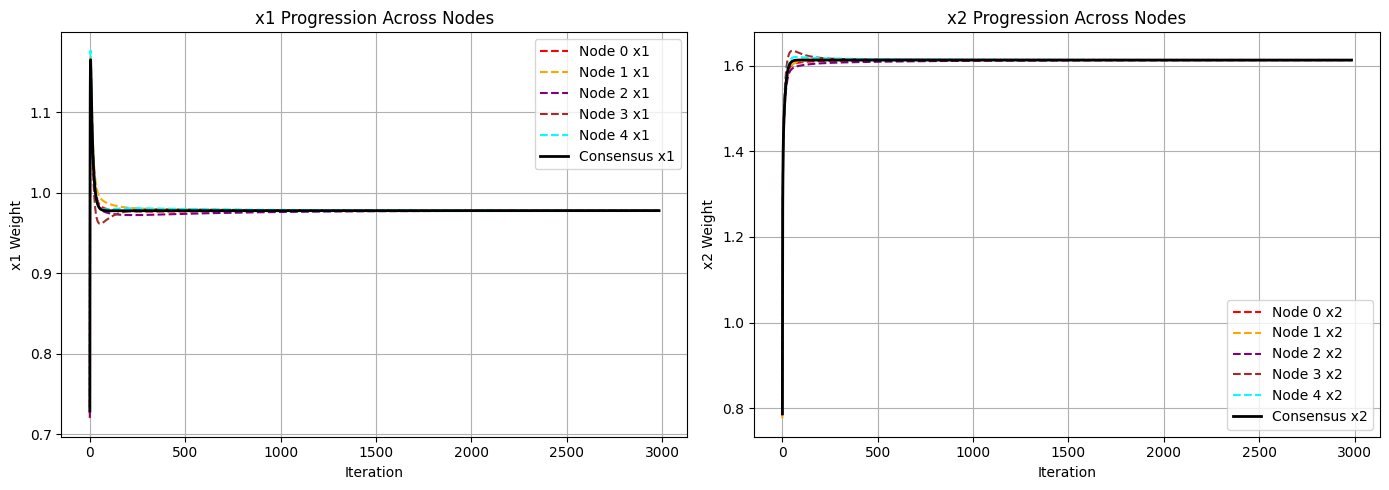

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Load Global Consensus Data
df_global = pd.read_csv('global_progress.csv')

# Load Node Data
node_data = []
for node in range(5):
    filename = f'node_{node}_progress.csv'
    df_node = pd.read_csv(filename)
    node_data.append(df_node)

colors = ['red', 'orange', 'purple', 'brown', 'cyan']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot x1 Progression
for node in range(5):
    axes[0].plot(node_data[node]['iteration'], node_data[node]['x1'],
                 label=f'Node {node} x1', color=colors[node], linestyle='--')
axes[0].plot(df_global['iteration'], df_global['x1'], label='Consensus x1', color='black', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('x1 Weight')
axes[0].set_title('x1 Progression Across Nodes')
axes[0].grid(True)
# axes[0].set_xscale('log')
axes[0].legend()

# Plot x2 Progression
for node in range(5):
    axes[1].plot(node_data[node]['iteration'], node_data[node]['x2'],
                 label=f'Node {node} x2', color=colors[node], linestyle='--')
axes[1].plot(df_global['iteration'], df_global['x2'], label='Consensus x2', color='black', linewidth=2)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('x2 Weight')
#make x logscale
# axes[1].set_xscale('log')
axes[1].set_title('x2 Progression Across Nodes')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()
